In [1]:
from __future__ import print_function

import numpy as np

import itertools

import tensorflow as tf
from autoencoder import model
import pickle

import os

In [2]:
DEBUG = False
PLOTTING_SUPPORT = True
RUN_AS_PY_SCRIPT = False
SET_EULER_PARAMS = False
SET_MARMOT_PARAMS = False

# Handle arguments (When executed as .py script)
import sys
argv = sys.argv[:]
if len(argv) > 1:
  script_path = argv.pop(0)
  if "--euler" in argv:
    import sys
    sys.stdout = open('stdout.txt', 'w')
    RUN_AS_PY_SCRIPT = True
    PLOTTING_SUPPORT = False
    SET_EULER_PARAMS = True
    print("Parameters set for execution on euler cluster")
    argv.remove("--euler")
  if "--marmot" in argv:
    RUN_AS_PY_SCRIPT = True
    PLOTTING_SUPPORT = False
    SET_MARMOT_PARAMS = True
    print("Parameters set for execution on marmot cluster")
    argv.remove("--marmot") 
  if "--script" in argv:
    RUN_AS_PY_SCRIPT = True
    PLOTTING_SUPPORT = False
    print("Running as script")
    argv.remove("--script") 

In [3]:
if not RUN_AS_PY_SCRIPT:
  %load_ext autoreload
  %autoreload 2
  from IPython.display import clear_output
  if PLOTTING_SUPPORT:
    %matplotlib notebook
    from matplotlib import pyplot as plt

## Parameters

In [41]:
BATCH_SIZE = 10
VOXEL_SIDE = 24

MAX_STEPS = 10000
VAL_EXAMPLES = 200
N_ROTATION_ANGLES = 12
ROTATION_OFFSET = 0
VAL_EVERY_N_STEPS = 1
VAL_STEP_TOLERANCE = 10
ROTATE_SEGMENTS_EVERY_STEP = True
G_THRESHOLD = 0.80
D_THRESHOLD = 0.45

MP = model.ModelParams()
MP.INPUT_SHAPE = [VOXEL_SIDE, VOXEL_SIDE, VOXEL_SIDE, 1]

HOME_DIR = os.path.expanduser('~')
DATA_DIR = os.path.expanduser("~/.segmatch/database/")
RUN_NAME = "kitti18"
RESTORE_MODEL = True
SAVE_DIR = HOME_DIR + "/Desktop/autoencoder/"
SAVE_FILE = "model.checkpoint"
MP_FILENAME = "model_params.pckl"
#TENSORBOARD_DIR = "/tmp/tf_log"
TENSORBOARD_DIR = None
SAVE_DIR_NOVAL = "/tmp/unvalidated/"
SAVE_UNVALIDATED = True
CREATE_VISUALS = False
DETAILED_STEP_TIMES = False

EXPORT_FEATURES = False

In [10]:
if SET_EULER_PARAMS:
    DATA_DIR = "/cluster/home/dugasd/database/"
    SAVE_DIR = "/cluster/home/dugasd/autoencoder-euler/"
    TENSORBOARD_DIR = None
    CREATE_VISUALS = False
    
    MAX_STEPS = 1000000
    VAL_STEP_TOLERANCE = 5
    
if SET_MARMOT_PARAMS:
    DATA_DIR = "/home/daniel/database/"
    RUN_NAME = "kitti18-20-27"
    SAVE_DIR = "/home/daniel/autoencoder-marmot/"
    SAVE_UNVALIDATED = True
    TENSORBOARD_DIR = None
    CREATE_VISUALS = False
    
    MAX_STEPS = 1000000
    VAL_STEP_TOLERANCE = 10
    
if not RUN_AS_PY_SCRIPT:
    MP.CONVOLUTION_LAYERS = []
    CREATE_VISUALS = True

In [15]:
if RUN_AS_PY_SCRIPT:
  while argv:
      arg = argv.pop(0)
      if arg == "-RUN_NAME":
        RUN_NAME = argv.pop(0)
        print("RUN_NAME set to " + RUN_NAME)
      elif arg == "-SAVE_DIR":
        SAVE_DIR = argv.pop(0)
        print("SAVE_DIR set to " + SAVE_DIR)
      elif arg == "-BATCH_SIZE":
        BATCH_SIZE = int(argv.pop(0))
        print("BATCH_SIZE set to " + str(BATCH_SIZE))
      elif arg == "--noconv":
        MP.CONVOLUTION_LAYERS = []
        print("CONVOLUTION LAYERS REMOVED")
      elif arg == "--no_rotation":
        ROTATE_SEGMENTS_EVERY_STEP = False
        print("Disabling segment rotation.")
      elif arg == "-LEARNING_RATE":
        MP.LEARNING_RATE = float(argv.pop(0))
        print("LEARNING_RATE set to " + str(MP.LEARNING_RATE))
      elif arg == "-LATENT_SHAPE":
        MP.LATENT_SHAPE = [int(argv.pop(0))]
        print("LATENT_SHAPE set to " + str(MP.LATENT_SHAPE))
      elif arg == "-VAL_STEP_TOLERANCE":
        VAL_STEP_TOLERANCE = int(argv.pop(0))
        print("VAL_STEP_TOLERANCE set to " + str(VAL_STEP_TOLERANCE))
      elif arg == "-ROTATION_OFFSET":
        frac = list(map(float, argv.pop(0).split('/'))) + [1.0]
        ROTATION_OFFSET = frac[0]/frac[1]
        print("ROTATION_OFFSET set to " + str(ROTATION_OFFSET))
      elif arg == "--float64":
        MP.FLOAT_TYPE = tf.float64
        print("MP.FLOAT_TYPE set to " + str(MP.FLOAT_TYPE))
      elif arg == "--not-vegan":
        MP.ADVERSARIAL = False
        MP.MUTUAL_INFO = False
        print("Reverting to variational autoencoder model only.")
      elif arg == "--vegan":
        MP.ADVERSARIAL = True
        MP.MUTUAL_INFO = True
        print("Enabling adversarial and mutual info graphs.")
      else:
        print("Unknown argument: " + arg)
        raise NotImplementedError

In [16]:
SAVE_PATH = SAVE_DIR+SAVE_FILE

## Load Segments and Features

In [17]:
import utilities
run_names, runs = utilities.list_runs(DATA_DIR)
try:
  run_names.remove(RUN_NAME)
  run_names = [RUN_NAME] + run_names
except:
  print(RUN_NAME + " not found in runs.")
  print(run_names)
print(run_names)

kitti18 not found in runs.
['kitti18-first200', 'modelnet40-first400']
['kitti18-first200', 'modelnet40-first400']


In [18]:
if not RUN_AS_PY_SCRIPT:
  from ipywidgets import widgets
  run_dropdown = widgets.Dropdown(description="Run to import : ", options=run_names)
  button = widgets.Button(description="import")

  # Interaction functions
  def import_run_data(btn):
    display.clear_output()
    print("Loading segments, features, matches, classes for run")
    global segments, features, fnames, matches, classes, ids, classes_set # 'output' variables
    segments, features, fnames, matches, classes, ids = utilities.import_run(run_dropdown.value, folder=DATA_DIR)
    classes_set = sorted(list(set(classes)))
  
  button.on_click(import_run_data)
  # Display widgets
  from IPython import display
  display.display(run_dropdown)
  display.display(button)

  import_run_data(button)
else:
  segments, features, fnames, matches, classes, ids = utilities.import_run(RUN_NAME, folder=DATA_DIR)
  classes_set = sorted(list(set(classes)))

Loading segments, features, matches, classes for run
  Found 200 segments
  Found features for 200 segments 
  Found 0 groups of matches
  Found 200 segment ids
  Found classes for 200 segments


/home/daniel/Code/Vitrified-Code/Python/segmatch_python/import_export.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  extracted_data = read_csv(folder+filename, delimiter=' ').as_matrix()


## Create Autoencoder

In [23]:
if not RUN_AS_PY_SCRIPT:
  try:
    stored_MP = pickle.load(open(SAVE_DIR+MP_FILENAME, 'rb'))
    if MP != stored_MP: 
        print("WARNING: Setting params for compatibility with stored model.")
        print("Stored model: "); print(stored_MP); print("New model: "); print(MP)
    MP = stored_MP
  except FileNotFoundError:
    print("No stored model found. Creating a new model.")
temp = MP.DISABLE_SUMMARY
MP.DISABLE_SUMMARY = True if TENSORBOARD_DIR is None else False
if MP.DISABLE_SUMMARY != temp: print("Summary", "enabled" if not MP.DISABLE_SUMMARY else "disabled")

No stored model found. Creating a new model.


In [26]:
vae = model.Autoencoder(MP)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [30]:
summary_writer = None
if TENSORBOARD_DIR != None:
  summary_writer = tf.train.SummaryWriter(TENSORBOARD_DIR, vae.sess.graph)
  print("Graph written to log.")

In [31]:
if RESTORE_MODEL:
  try:
    vae.saver.restore(vae.sess, SAVE_PATH)
    print("Model restored.")
    print(MP.CONVOLUTION_LAYERS)
  except Exception as err:
    print("Could not load model: ", end="")
    try:
      stored_MP = pickle.load(open(SAVE_DIR+MP_FILENAME, 'rb'))
    except FileNotFoundError:
        print("no model folder.")
    else:
      print("ERROR: mismatch between model params.")
      print("Stored model: "); print(stored_MP); print("New model: "); print(MP)
      raise err

INFO:tensorflow:Restoring parameters from /home/daniel/Desktop/autoencoder/model.checkpoint
Could not load model: no model folder.


## Create Voxelized Segment Dataset - With Rotated Copies

In [32]:
## Split into training and val data
split_at = min(VAL_EXAMPLES, int(0.2 * len(ids)))
val = segments[:split_at]
train = segments[split_at:]

In [33]:
from voxelize import voxelize
if not ROTATE_SEGMENTS_EVERY_STEP:
  print("Voxelizing training data")
  train_vox, _ = voxelize(train,VOXEL_SIDE)

  del train # Save some memory
val_vox, _   = voxelize(val  ,VOXEL_SIDE)

In [34]:
import os
import psutil
process = psutil.Process(os.getpid())
print("Using " + str(process.memory_info().rss/(1024.0*1024.0)) + "mB of memory")

ImportError: No module named 'psutil'

## Train Autoencoder ( Computationally Intensive )

Previous cost log found.


<IPython.core.display.Javascript object>


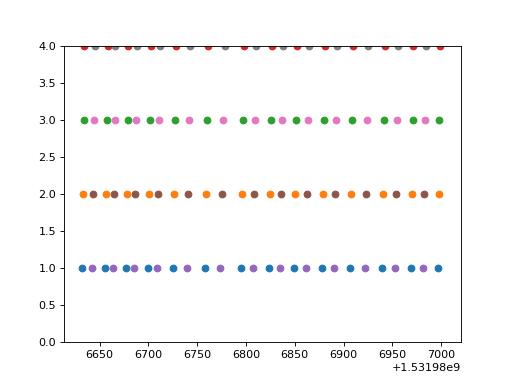

Validation cost: 0.1320372  (Training cost: None) Step Time: -112.79507026400006


<IPython.core.display.Javascript object>


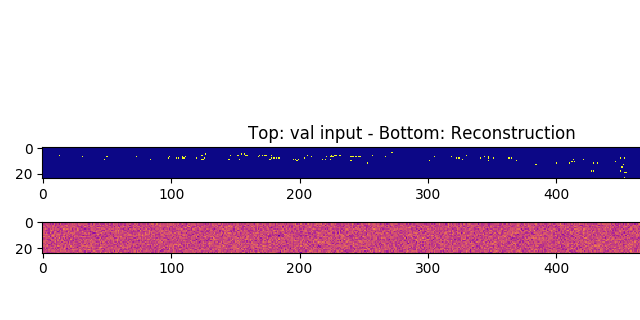

<IPython.core.display.Javascript object>


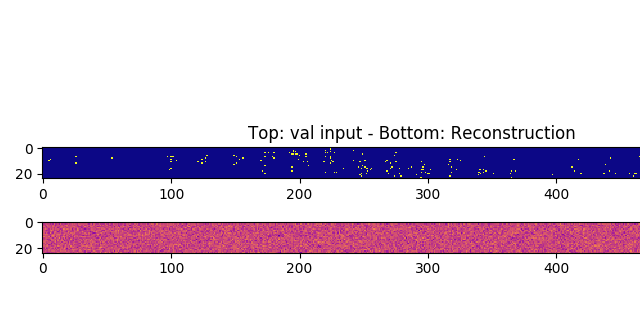

<IPython.core.display.Javascript object>


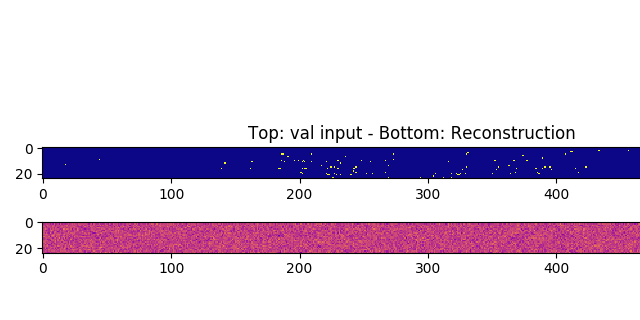

<IPython.core.display.Javascript object>


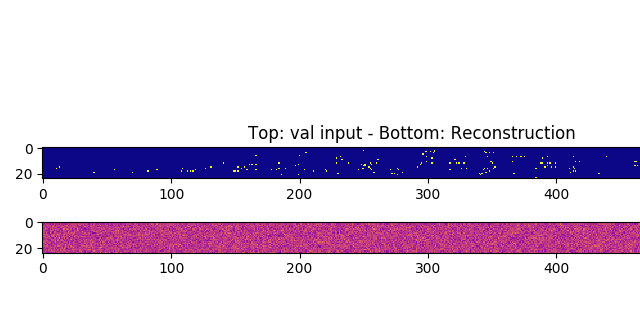

<IPython.core.display.Javascript object>


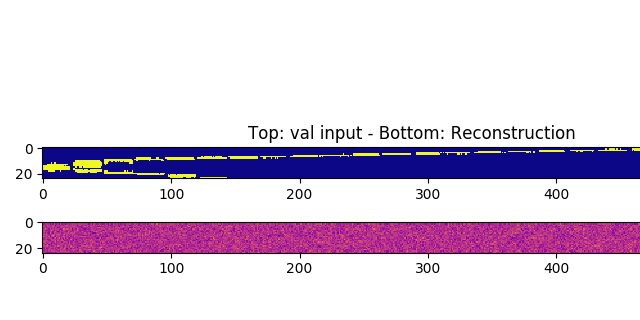

<IPython.core.display.Javascript object>


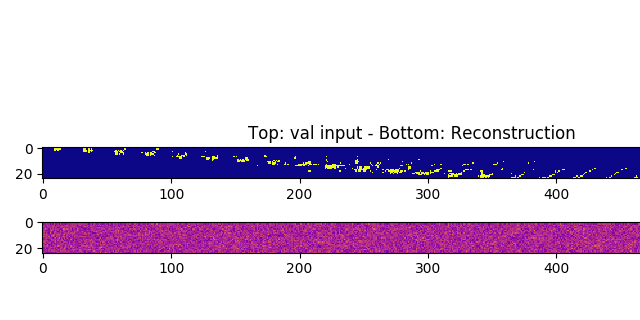

<IPython.core.display.Javascript object>


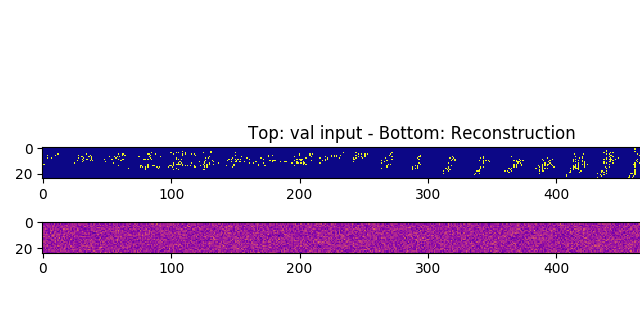

<IPython.core.display.Javascript object>


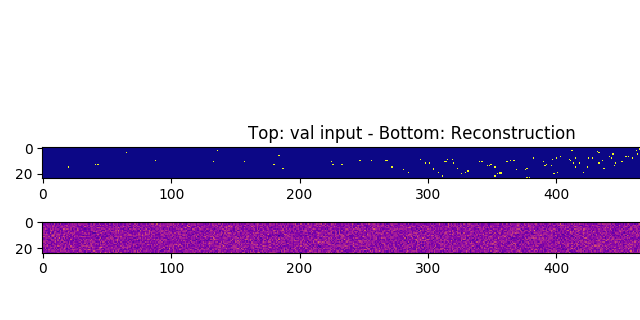

<IPython.core.display.Javascript object>


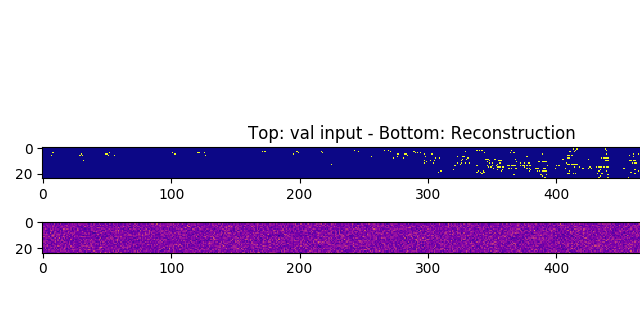

<IPython.core.display.Javascript object>


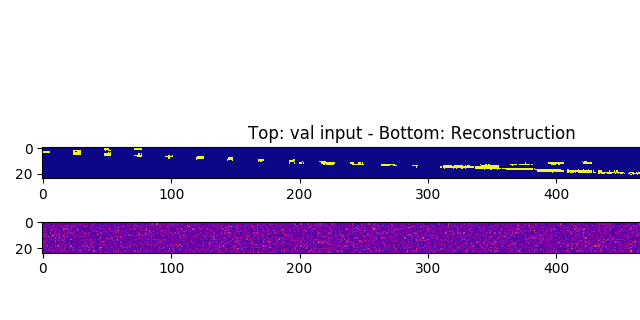

<IPython.core.display.Javascript object>


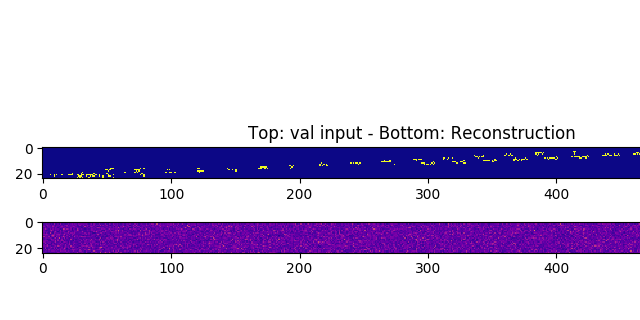

<IPython.core.display.Javascript object>


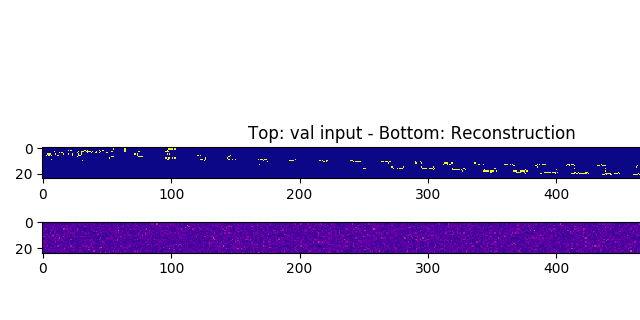

<IPython.core.display.Javascript object>


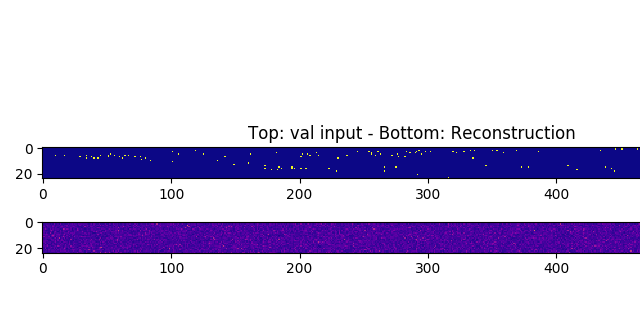

<IPython.core.display.Javascript object>


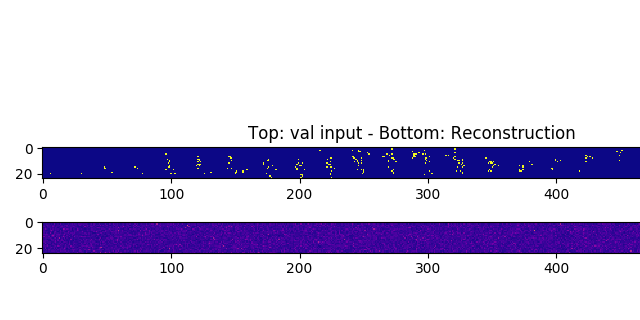

<IPython.core.display.Javascript object>


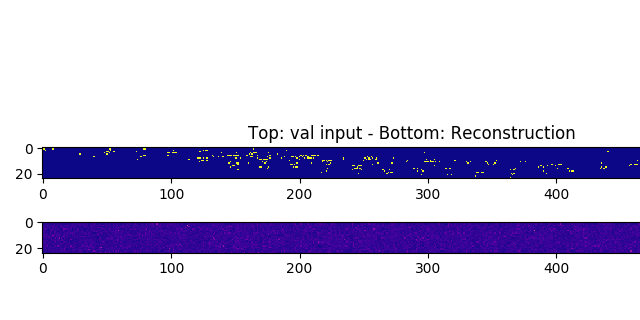

<IPython.core.display.Javascript object>


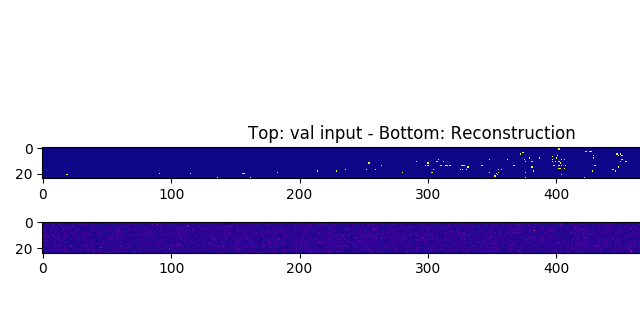

<IPython.core.display.Javascript object>


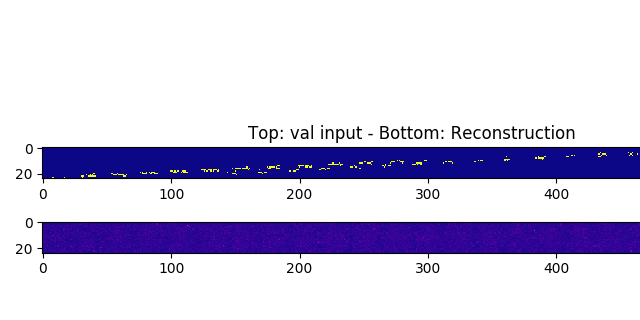

<IPython.core.display.Javascript object>


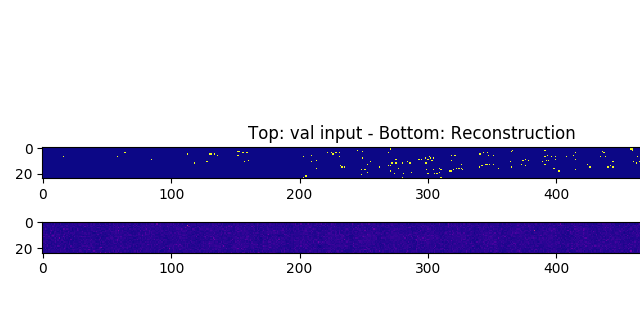

/home/daniel/segmappyenv/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


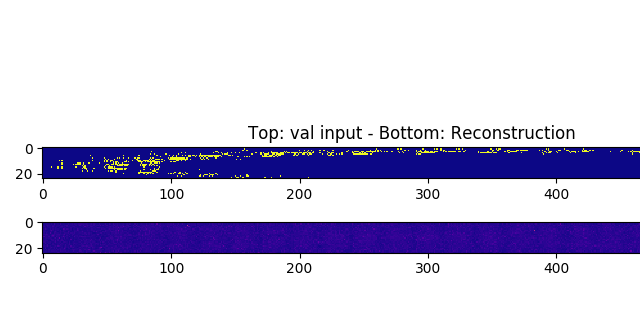

<IPython.core.display.Javascript object>


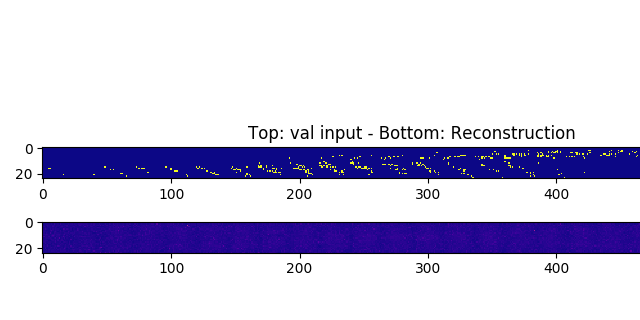

<IPython.core.display.Javascript object>


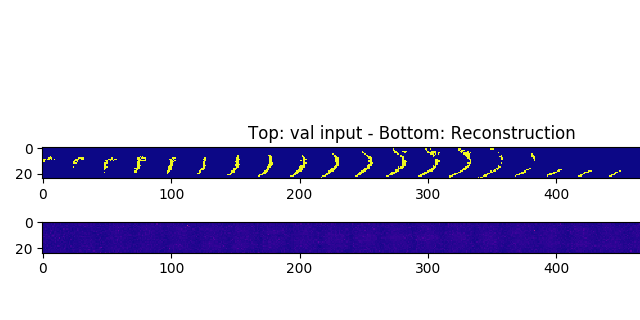

<IPython.core.display.Javascript object>


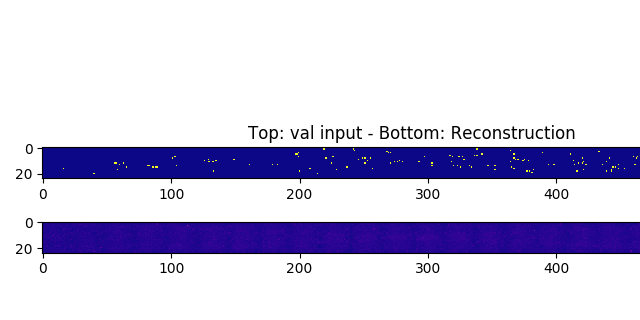

<IPython.core.display.Javascript object>


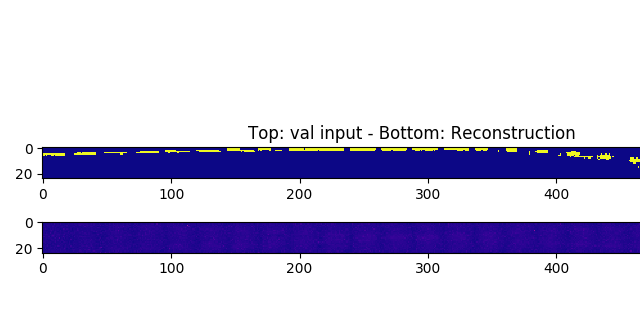

<IPython.core.display.Javascript object>


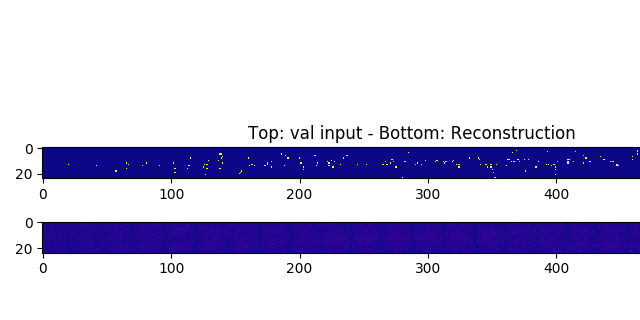

<IPython.core.display.Javascript object>


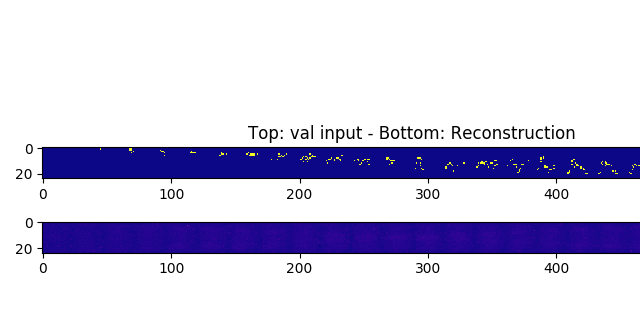

<IPython.core.display.Javascript object>


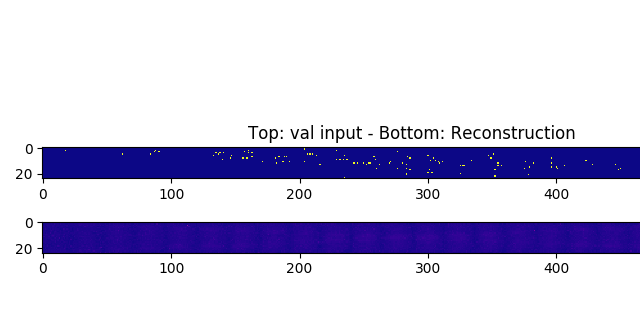

<IPython.core.display.Javascript object>


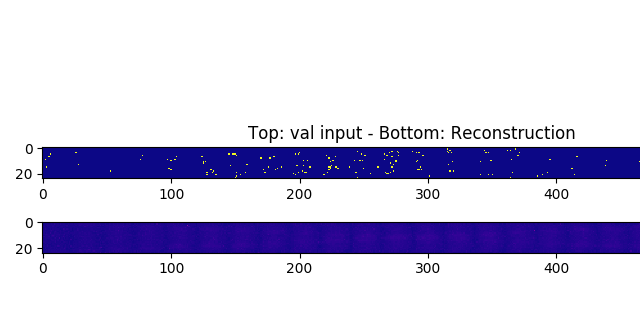

<IPython.core.display.Javascript object>


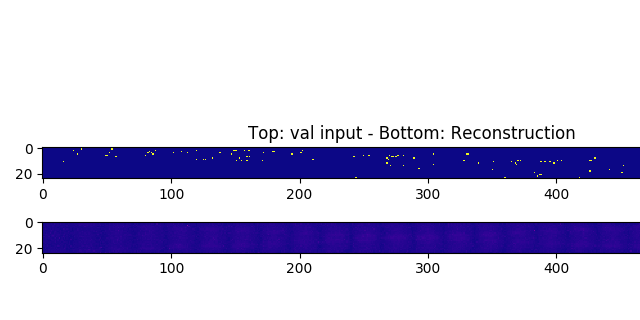

<IPython.core.display.Javascript object>


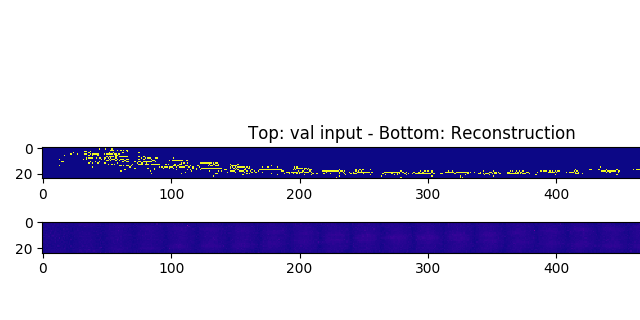

<IPython.core.display.Javascript object>


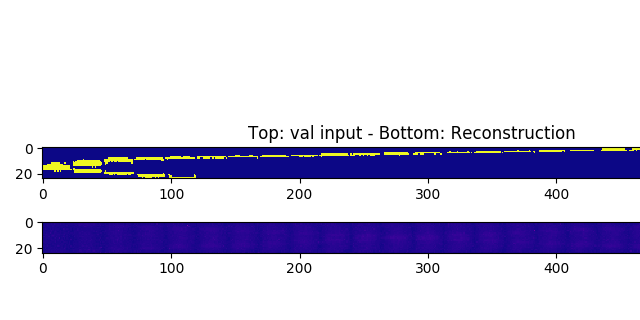

<IPython.core.display.Javascript object>


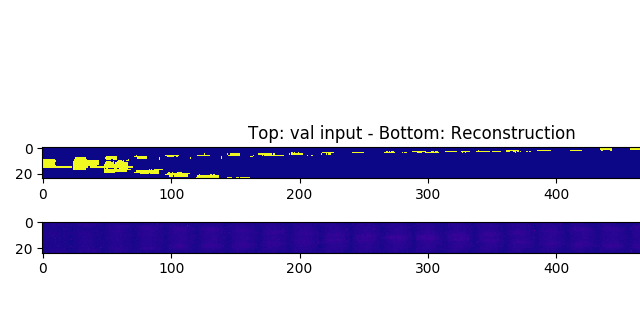

<IPython.core.display.Javascript object>


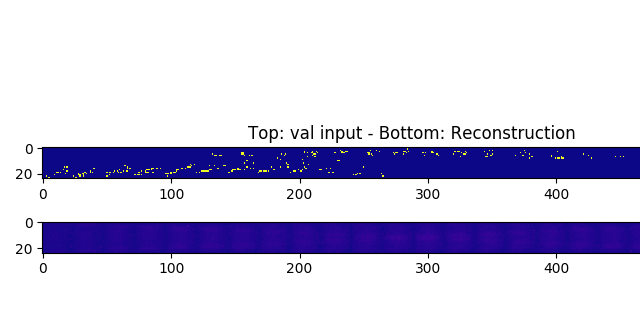

<IPython.core.display.Javascript object>


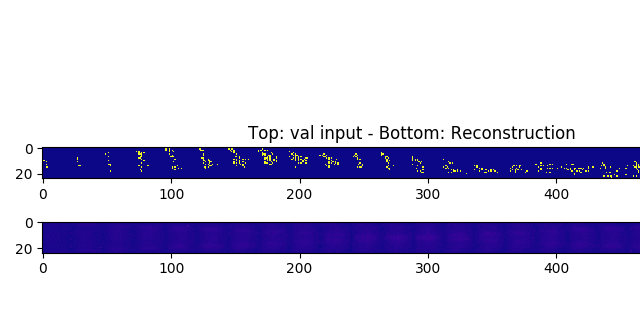

<IPython.core.display.Javascript object>


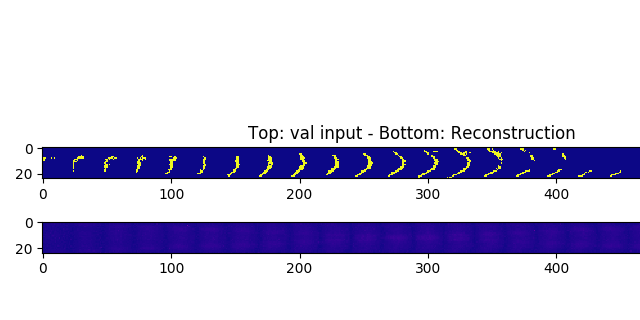

<IPython.core.display.Javascript object>


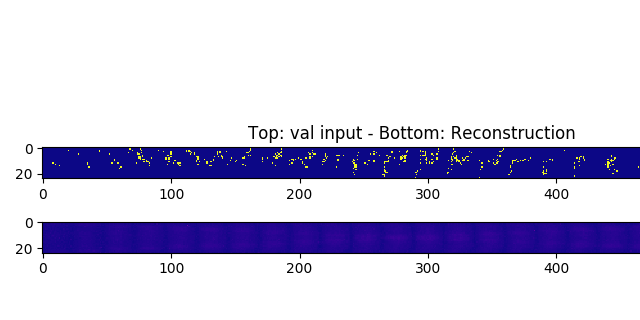

<IPython.core.display.Javascript object>


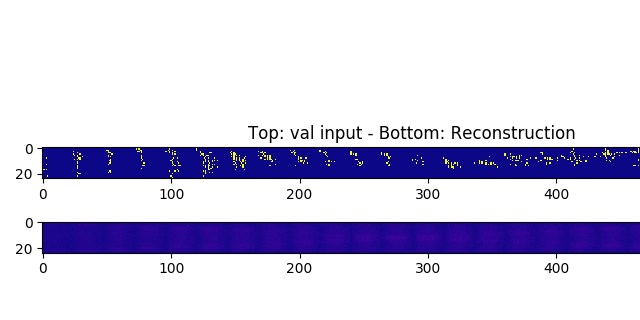

<IPython.core.display.Javascript object>


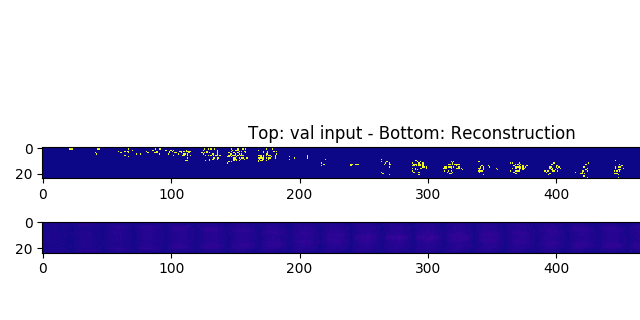

<IPython.core.display.Javascript object>


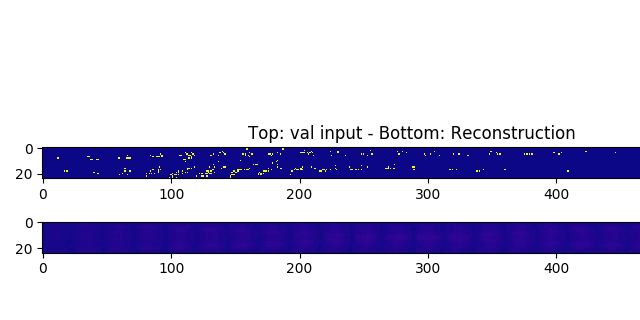

<IPython.core.display.Javascript object>


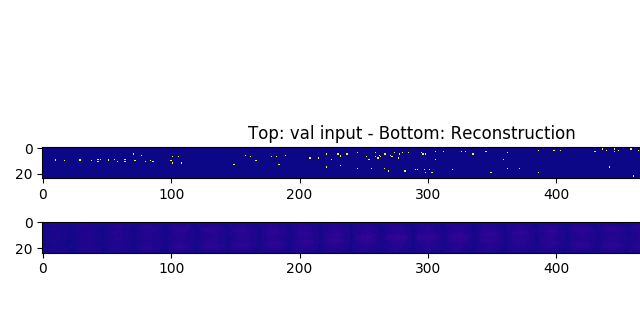

<IPython.core.display.Javascript object>


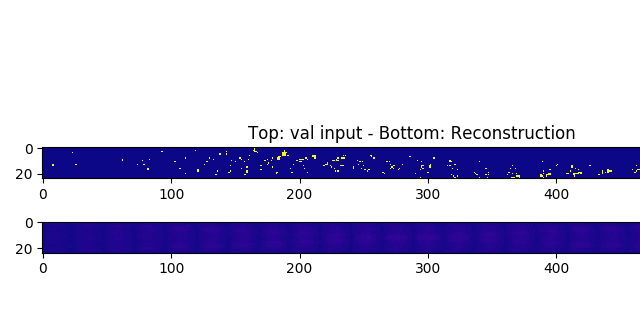

Validation cost: 0.1341839  (Training cost: 0.26105487) Step Time: 13.624419087000206


/home/daniel/segmappyenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


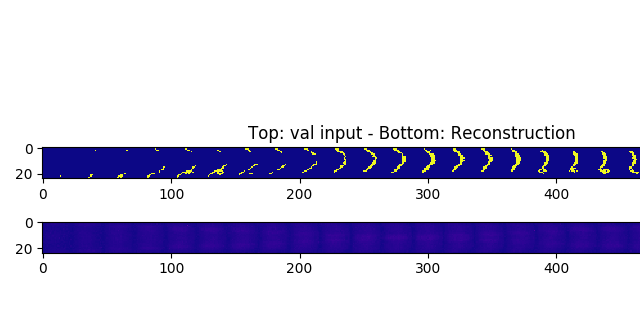

Validation cost: 0.13026008  (Training cost: 0.26283512) Step Time: 13.484299558999737


<IPython.core.display.Javascript object>


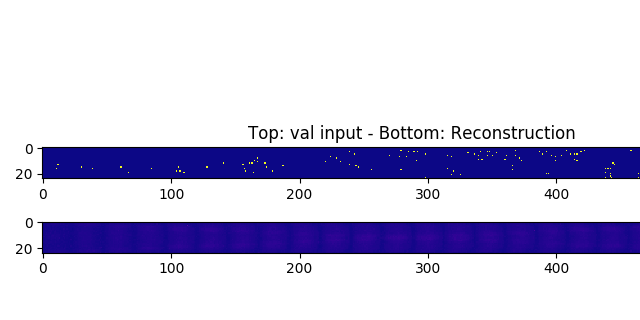

Saving ... Model saved in file: /home/daniel/Desktop/autoencoder/model.checkpoint
Validation cost: 0.1314347  (Training cost: 0.2611564) Step Time: 14.292469868999433


<IPython.core.display.Javascript object>


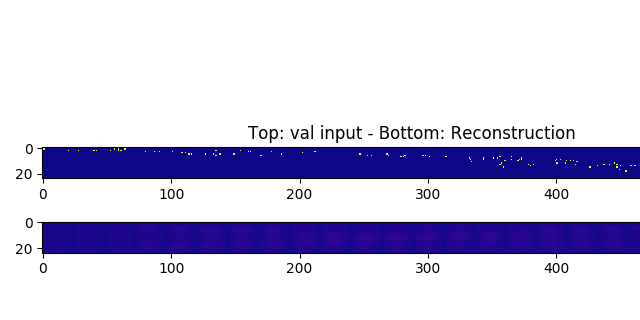

Validation cost: 0.1324062  (Training cost: 0.26003802) Step Time: 16.36382040799981


<IPython.core.display.Javascript object>


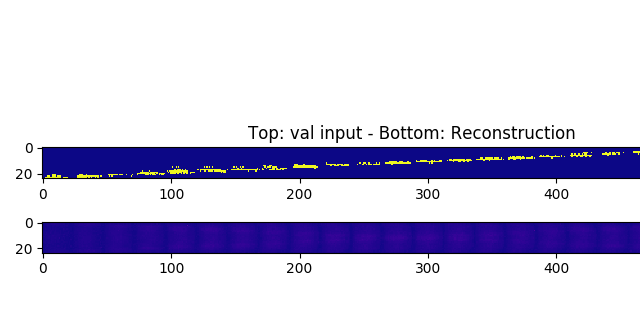

Validation cost: 0.13215303  (Training cost: 0.26210287) Step Time: 18.46176229199955


<IPython.core.display.Javascript object>


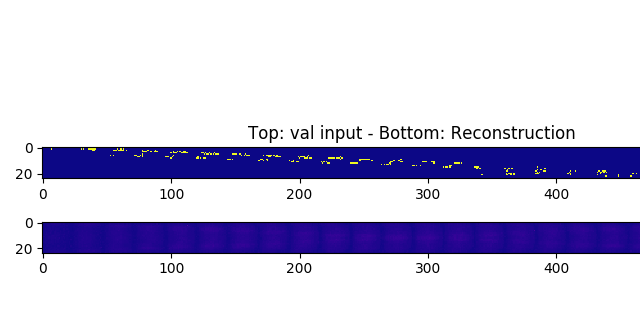

Validation cost: 0.13251808  (Training cost: 0.257637) Step Time: 22.687770311999884


<IPython.core.display.Javascript object>


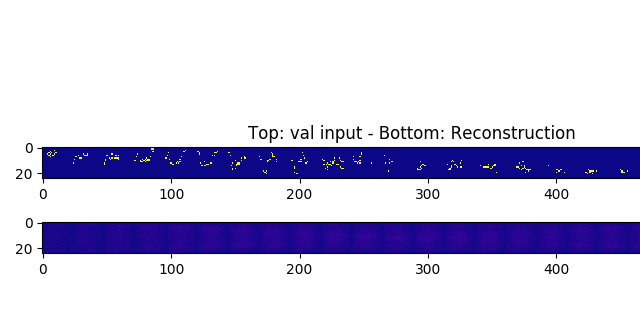

Validation cost: 0.13386977  (Training cost: 0.26132613) Step Time: 16.348780090999753


<IPython.core.display.Javascript object>


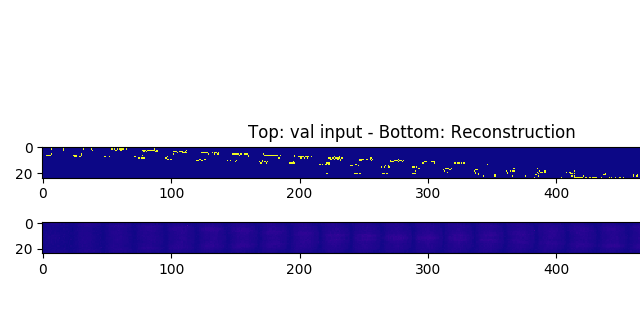

Validation cost: 0.13342732  (Training cost: 0.25931874) Step Time: 15.279831578000085


<IPython.core.display.Javascript object>


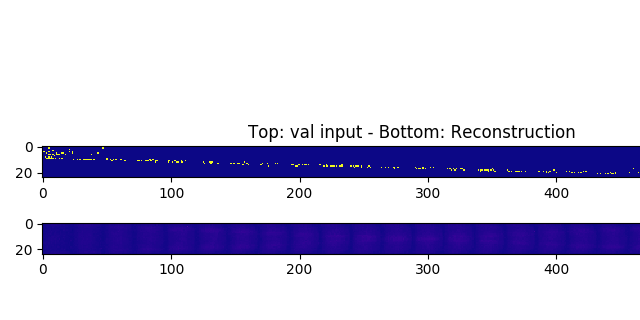

Validation cost: 0.13437581  (Training cost: 0.2586073) Step Time: 15.545827963000193


<IPython.core.display.Javascript object>


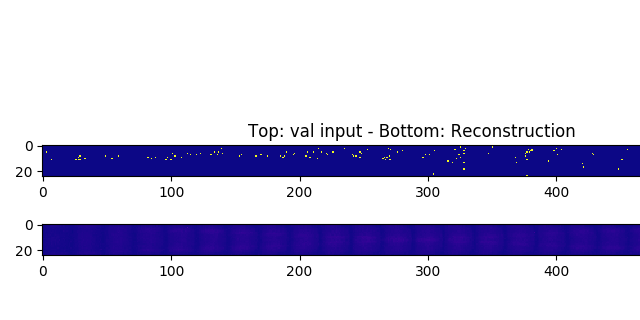

Validation cost: 0.13084899  (Training cost: 0.25947893) Step Time: 16.613452866999978


<IPython.core.display.Javascript object>


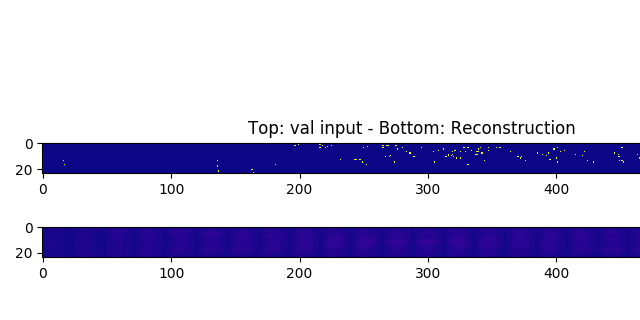

Validation cost: 0.13483734  (Training cost: 0.25894648) Step Time: 17.949494591000075


<IPython.core.display.Javascript object>


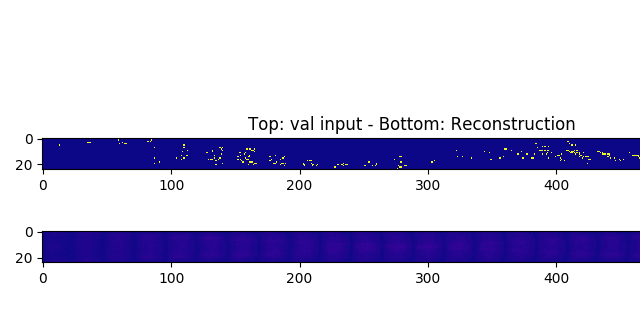

Validation cost: 0.13332981  (Training cost: 0.2623346) Step Time: 16.47750009399988


<IPython.core.display.Javascript object>


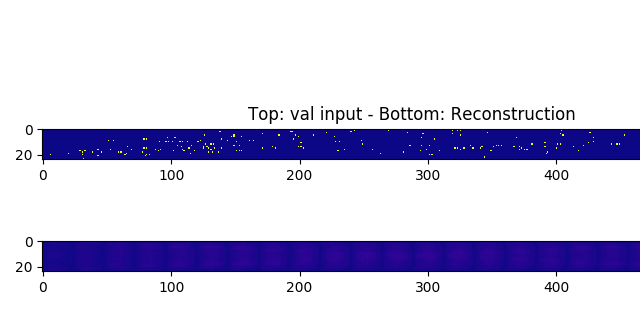

Validation cost: 0.13074937  (Training cost: 0.26214844) Step Time: 15.00334763400042


<IPython.core.display.Javascript object>


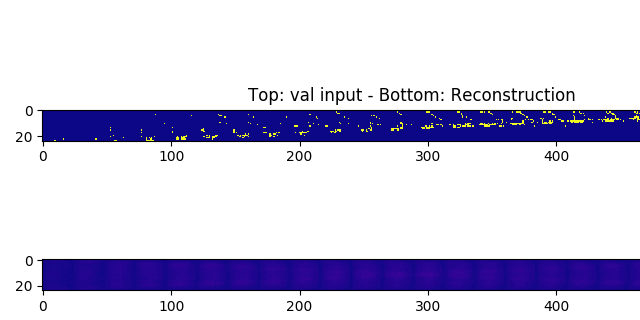

Training stopped by validation monitor.
Training ended.

Saving ... Unvalidated model saved in file: /tmp/unvalidated/model.checkpoint


In [42]:
from timeit import default_timer as timer
from dynamic_average import Average
from autoencoder.batchmaker import Batchmaker, progress_bar

avg_step_cost = None
step_cost_log = []
val_steps_since_last_improvement = 0
step_start = timer()

try:
    val_cost_log = list(np.loadtxt(SAVE_DIR+"val_cost_log.txt"))
    print("Previous cost log found.")
except:
    val_cost_log = []
    
# single step
try:
    for step in range(MAX_STEPS):
      if ROTATE_SEGMENTS_EVERY_STEP:
          from voxelize import random_rotated
          val = random_rotated(val)
          train = random_rotated(train)
          from voxelize import voxelize
          train_vox, _ = voxelize(train,VOXEL_SIDE)
          val_vox, _   = voxelize(val ,VOXEL_SIDE)  # Validation
      val_batchmaker = Batchmaker(val_vox, BATCH_SIZE, MP)
      if np.mod(step, VAL_EVERY_N_STEPS) == 0:
        avg_val_cost = Average()
        while True:
          if val_batchmaker.is_depleted():
            break
          else:
            batch_input_values = val_batchmaker.next_batch()
            cost_value = vae.cost_on_single_batch(batch_input_values, summary_writer=summary_writer)
            avg_val_cost.add(cost_value)
            if PLOTTING_SUPPORT:
              progress_bar(val_batchmaker)
        print("Validation cost: "+str(avg_val_cost)+"  (Training cost: "+str(avg_step_cost)+")", end="")
        try:
          print(" Step Time: " + str(step_end-step_start))
          if DETAILED_STEP_TIMES:
            print(step_times)
        except: 
            print(" ")

        val_cost_log.append(avg_val_cost.values)


        if PLOTTING_SUPPORT:
          # Plot a few random samples
          import matplotlib.pyplot as plt
          n_samples = 1
          import random
          x_samples = random.sample(val_vox, n_samples)
          x_samples = [np.reshape(sample, MP.INPUT_SHAPE) for sample in x_samples]
          x_reconstruct = list(vae.encode_decode(x_samples))
          try:
            sample_history += x_samples
            recons_history += x_reconstruct
          except NameError:
            sample_history = x_samples
            recons_history = x_reconstruct
          for i, (in_, out_) in enumerate(zip(sample_history, recons_history)):
            plt.figure("reconstruction for step "+str(i), figsize=(8, 4))
            plt.subplot(2, 1, 1)
            plt.imshow(in_.reshape(VOXEL_SIDE, VOXEL_SIDE*VOXEL_SIDE), vmin=0, vmax=1, cmap='plasma')
            plt.title("Top: val input - Bottom: Reconstruction")
            plt.subplot(2, 1, 2)
            plt.imshow(out_.reshape(VOXEL_SIDE, VOXEL_SIDE*VOXEL_SIDE), vmin=0, vmax=1, cmap='plasma')
            plt.tight_layout()
            plt.show()
            plt.gcf().canvas.draw()

        # Training Monitor
        if len(val_cost_log) > 1:
            # Save cost log.
            import os
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)
                print("Created directory: %s" % SAVE_DIR)
                with open(SAVE_DIR+MP_FILENAME, 'wb') as file:
                  pickle.dump(MP, file, protocol=2)
            np.savetxt(SAVE_DIR+"val_cost_log.txt", val_cost_log)
            # Save if cost has improved. Otherwise increment counter.
            if np.less(val_cost_log[-1], np.min(val_cost_log[:-1], 0))[0]:
                val_steps_since_last_improvement = 0
                # save model to disk
                print("Saving ... ", end='')
                save_path = vae.saver.save(vae.sess, SAVE_PATH)
                print("Model saved in file: %s" % save_path)      
            else:
                val_steps_since_last_improvement += 1  
        # Stop training if val_cost hasn't improved in VAL_STEP_TOLERANCE steps
        if val_steps_since_last_improvement > VAL_STEP_TOLERANCE:
            print("Training stopped by validation monitor.")
            break

      # Train on batches
      step_start = timer()
      zero = timer() - timer()
      step_times = {'batchmaking': zero, 'training': zero, 'plotting': zero}
      avg_step_cost = Average()
      training_batchmaker = Batchmaker(train_vox, BATCH_SIZE, MP)
      if MP.ADVERSARIAL:
        train_order = 4*[vae.optimizer] + 4*[vae.generator_optimizer] + [vae.discriminator_optimizer]
      elif MP.MUTUAL_INFO:
        train_order = [vae.optimizer, vae.optimizer_with_MI]
      else:
        train_order = [vae.optimizer]
      for train_target in itertools.cycle(train_order):
        if MP.ADVERSARIAL:
          if train_target is vae.discriminator_optimizer:
            if cost_value[1] > G_THRESHOLD or cost_value[2] < D_THRESHOLD:
              continue
        if training_batchmaker.is_depleted():
          break
        else:
          t_a = timer()  
          batch_input_values = training_batchmaker.next_batch()
          t_b = timer()
          # Train over 1 batch.
          cost_value = vae.train_on_single_batch(batch_input_values, train_target=train_target, summary_writer=summary_writer)
          avg_step_cost.add(cost_value)
          t_c = timer()
          if PLOTTING_SUPPORT:
            progress_bar(training_batchmaker)
          t_d = timer()
          step_times['batchmaking'] += t_b - t_a
          step_times['training']    += t_c - t_b
          step_times['plotting']    += t_d - t_c
      step_cost_log.append(avg_step_cost.values)
      step_end = timer()
except KeyboardInterrupt:
    print("Training interrupted.")
else:
    print("Training ended.")
    
if SAVE_UNVALIDATED:
    SAVE_PATH_NOVAL = SAVE_DIR_NOVAL+SAVE_FILE
    try: 
        os.makedirs(SAVE_DIR_NOVAL)
        print("Directory created", SAVE_DIR_NOVAL)
    except:
        print("")
    print("Saving ... ", end='')
    save_path = vae.saver.save(vae.sess, SAVE_PATH_NOVAL)
    print("Unvalidated model saved in file: %s" % save_path)

In [ ]:
if CREATE_VISUALS:
  raise ValueError('Training ended.')

## Visualize Autoencoder Performance

<IPython.core.display.Javascript object>


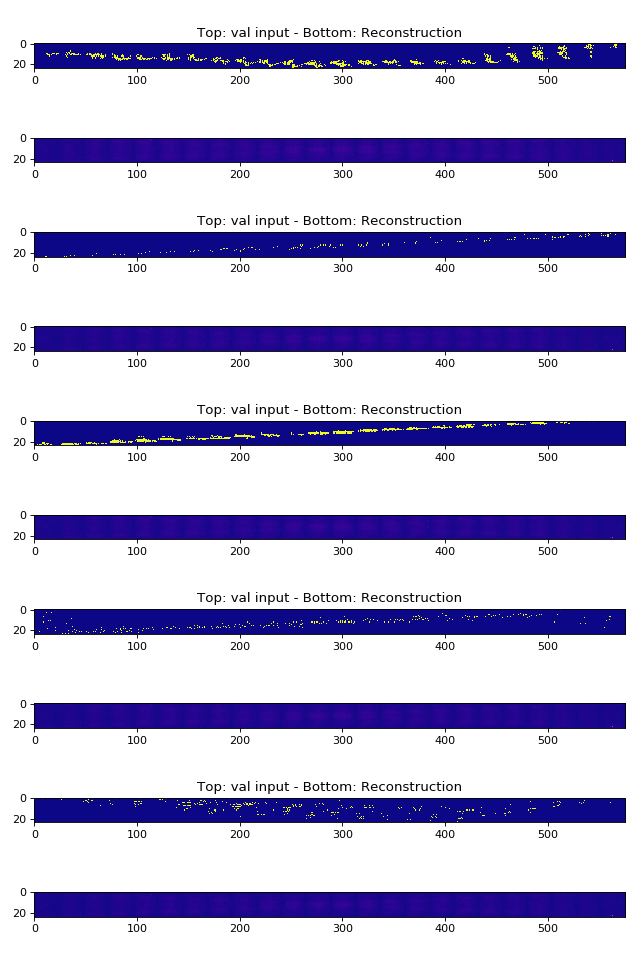

In [39]:
if PLOTTING_SUPPORT:
  # Plot a few random samples
  import matplotlib.pyplot as plt
  %matplotlib notebook
  plt.ion()
  n_samples = 5
  import random
  x_samples = random.sample(val_vox, 5)
  x_samples = [np.reshape(sample, MP.INPUT_SHAPE) for sample in x_samples]
  x_reconstruct = vae.encode_decode(x_samples)
  plt.figure(figsize=(8, 12))
  for i in range(n_samples):
    plt.subplot(n_samples*2, 1, 2*i + 1)
    plt.imshow(x_samples[i].reshape(VOXEL_SIDE, VOXEL_SIDE*VOXEL_SIDE), vmin=0, vmax=1, cmap='plasma')
    plt.title("Top: val input - Bottom: Reconstruction")
    plt.subplot(n_samples*2, 1, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(VOXEL_SIDE, VOXEL_SIDE*VOXEL_SIDE), vmin=0, vmax=1, cmap='plasma')
  plt.tight_layout()

In [ ]:
if PLOTTING_SUPPORT:
  nx = ny = 4
  nz = 1
  dim1 = 0
  dim2 = 1
  dim3 = 0
  x_values = np.linspace(-3, 3, nx)
  y_values = np.linspace(-3, 3, ny)
  z_values = np.linspace(-3, 3, nz)
  canvas = np.empty((VOXEL_SIDE*ny, VOXEL_SIDE*nx, VOXEL_SIDE*nz))
  for i, yi in enumerate(x_values):
      for j, xi in enumerate(y_values):
          for k, zi in enumerate(z_values):
              # we can only visualize 3 dimensions, in this case the first 3
              latent_sample = np.zeros([1]+MP.LATENT_SHAPE)
              latent_sample.flat[dim1] = xi
              latent_sample.flat[dim2] = yi
              latent_sample.flat[dim3] = zi
              x_mean = vae.decode(latent_sample)
              canvas[(nx-i-1)*VOXEL_SIDE:(nx-i)*VOXEL_SIDE,
                     j*VOXEL_SIDE:(j+1)*VOXEL_SIDE,
                     k*VOXEL_SIDE:(k+1)*VOXEL_SIDE] \
                   = x_mean[0].reshape(VOXEL_SIDE, VOXEL_SIDE, VOXEL_SIDE)
  from mpl_toolkits.mplot3d import Axes3D
  threshold = 0.7
  X,Y,Z = np.where(canvas > (threshold*np.max(canvas)))
  fig = plt.figure()
  plt.cla()
  ax = Axes3D(fig)
  ax.scatter(X, Y, Z)

## Compute Autoencoder Features for Segments

In [ ]:
if not RUN_AS_PY_SCRIPT:
  print("Voxelizing segments")
  from voxelize import voxelize
  segments_vox, features_voxel_scale = voxelize(segments, VOXEL_SIDE)

In [ ]:
if not RUN_AS_PY_SCRIPT:
    print("Computing Eigenvalue Features")
    from eigenvalues import eigenvalue_features
    features_eig = eigenvalue_features(segments)
    features_eig[np.where(np.isnan(features_eig))] = 0
    F = features_eig
    C = classes

In [ ]:
if not RUN_AS_PY_SCRIPT:
  print("Computing Features for Segments")
  features_nn, confusion_nn = vae.batch_encode([np.reshape(sample, MP.INPUT_SHAPE) for sample in segments_vox])
  fnames_nn = ['autoencoder_feature'+str(i+1) for i, _ in enumerate(features_nn[0])]
  F = features_nn
  C = classes

In [ ]:
if not RUN_AS_PY_SCRIPT:
  print("Rotating segments")
  from voxelize import create_rotations
  rotated_segments, rotated_classes = create_rotations(segments, N_ROTATION_ANGLES, classes=classes)
  if False: # walls_vs_cars
    print("Removing unknowns")
    rotated_segments = [segment for segment, class_ in zip(rotated_segments, rotated_classes) if class_ != "unknown"]
    rotated_classes = [class_ for class_ in rotated_classes if class_ != "unknown"]
  print("Voxelizing rotations")
  from voxelize import voxelize
  rotated_segments_vox, rotated_segments_scale = voxelize(rotated_segments, VOXEL_SIDE)
  print("Computing Features for rotations")
  rotated_features, _ = vae.batch_encode([np.reshape(sample, MP.INPUT_SHAPE) for sample in rotated_segments_vox])
  F = rotated_features
  C = rotated_classes

## T-SNE

In [ ]:
if not RUN_AS_PY_SCRIPT:
  print("T-SNE")
  dir_ = "/tmp/online_matcher/visuals/"
  import os
  if not os.path.exists(dir_):
    os.makedirs(dir_)
  if MP.LATENT_SHAPE[0] == 2:
    F2 = F
  else:
    from tools.tsne import tsne
    F2 = tsne(F, err_threshold=1.0)
  from itertools import cycle
  cnames = ['dodgerblue', 'gold', 'silver', 'tomato', 
            'plum', 'lemonchiffon', 'grey', 'orchid', 'lime', 'palegreen']
  from matplotlib import pyplot as plt
  plt.figure(figsize=(12,7))
  for c_, name in zip(cycle(cnames), classes_set):
    x = [values[0] for values, class_ in zip(F2, C) if class_ == name]
    y = [values[1] for values, class_ in zip(F2, C) if class_ == name]
    plt.scatter(x, y, c=c_, alpha=0.8,  lw = 0)
  box = plt.gca().get_position()
  plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
  ncol = 2 if len(classes_set) > 10 else 1
  plt.legend(classes_set, loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
  plt.title('T-SNE')
  plt.xlabel('x_dim')
  plt.ylabel('y_dim')
  plt.show()
  try:
    plt.gcf().savefig(dir_+"t-sne.png")
  except:
    print("not saved.")
  if len(matches) > 0:
    print("Adding matches")
    # Dim all points
    plt.cla()
    for c_, name in zip(cycle(cnames), classes_set):
      x = [values[0] for values, class_ in zip(F2, C) if class_ == name]
      y = [values[1] for values, class_ in zip(F2, C) if class_ == name]
      plt.scatter(x, y, c=c_, alpha=0.2,  lw = 0)
    plt.legend(classes_set, loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
    plt.title('T-SNE')
    plt.xlabel('x_dim')
    plt.ylabel('y_dim')
    # Bring out matched points
    matched_ids = [id_ for match in matches for id_ in match]
    for c_, name in zip(cycle(cnames), classes_set):
      x = [values[0] for values, class_, id_ in zip(F2, C, ids) if class_ == name and id_ in matched_ids]
      y = [values[1] for values, class_, id_ in zip(F2, C, ids) if class_ == name and id_ in matched_ids]
      plt.scatter(x, y, c=c_, s=30, lw = 1)
    # Show matches as lines
    for match in matches:
        line_x = [ F2[ids.index(match[0])][0], F2[ids.index(match[1])][0] ]
        line_y = [ F2[ids.index(match[0])][1], F2[ids.index(match[1])][1] ]
        plt.plot(line_x, line_y, 'black', linewidth=1)
        try:
            plt.gcf().savefig(dir_+"t-sne_matches.png")
        except:
            print("not saved.") 

## Reconstructions

In [ ]:
RC_CONFIDENCE = 0.1
ONEVIEW = True

In [ ]:
# Reconstructions
if not RUN_AS_PY_SCRIPT:
  N = 100
  SV_ = segments_vox[:N]
  S_ = segments[:N]
  I_ = ids[:N]
  reconstruction_vox = vae.batch_encode_decode([np.reshape(sample, MP.INPUT_SHAPE) for sample in SV_])
  reconstruction_vox = [np.reshape(vox, [VOXEL_SIDE, VOXEL_SIDE, VOXEL_SIDE]) for vox in reconstruction_vox]
  from voxelize import unvoxelize
  reconstruction = [unvoxelize(vox > RC_CONFIDENCE) for vox in reconstruction_vox]
  reconstruction = [segment*scale for (segment, scale) in zip(reconstruction, features_voxel_scale)]             
  if CREATE_VISUALS:
    dir_ = "/tmp/online_matcher/visuals/reconstructions/"
    from visuals import visuals_of_matches
    reconstruction_ids = [id_+max(I_)+1 for id_ in I_]
    one_to_one_matches = [[id1, id2] for id1, id2 in zip(I_, reconstruction_ids)]
    visuals_of_matches(one_to_one_matches, S_+reconstruction, I_+reconstruction_ids, directory=dir_, oneview=ONEVIEW)
    clear_output()

In [ ]:
# Exploring influence of first dimension on generated segments
dim_ = 0
if CREATE_VISUALS:
  # Use a pre-existing segment as starting point
  dir_ = "/tmp/online_matcher/visuals/gen_rotations/"
  class_name = "car"
  id_ = np.random.choice([id_ for id_, class_ in zip(ids, classes) if class_ == class_name])
  class_segments = [np.array(segments)[ids.index(id_)]]
  from voxelize import voxelize
  class_segments_vox, class_voxel_scale = voxelize(class_segments, VOXEL_SIDE)
  code, _ = vae.batch_encode([np.reshape(vox, MP.INPUT_SHAPE) for vox in class_segments_vox])
  code = code[0]
  
  values = [code[dim_]] + list(np.linspace(-10.,10.,10))
  gen_codes = []
  for value in values:
    gen_code = code
    gen_code[dim_] = value
    gen_codes.append(gen_code)
  gen_ids = range(len(gen_codes))
  
  gen_segments_vox = vae.batch_decode(gen_codes)
  gen_segments_vox = [np.reshape(vox, [VOXEL_SIDE, VOXEL_SIDE, VOXEL_SIDE]) for vox in gen_segments_vox]
  from voxelize import unvoxelize
  gen_segments = [unvoxelize(vox > RC_CONFIDENCE) for vox in gen_segments_vox]
  from visuals import visuals_of_segments
  visuals_of_segments(gen_segments, gen_ids, directory=dir_, oneview=ONEVIEW)
  clear_output()

In [ ]:
# Reconstructions of rotations for one object
if CREATE_VISUALS:
  dir_ = "/tmp/online_matcher/visuals/rotations/"
  class_name = "car"
  class_ids = [np.random.choice([id_ for id_, class_ in zip(ids, classes) if class_ == class_name])]
  class_indices = [ids.index(id_) for id_ in class_ids]
  class_segments = np.array(segments)[class_indices]
  
  from voxelize import create_rotations
  class_rotated_segments = np.array(list(class_segments) + list(create_rotations(class_segments, N_ROTATION_ANGLES)))
  from voxelize import voxelize
  class_segments_vox, class_voxel_scale = voxelize(class_rotated_segments, VOXEL_SIDE)
  if CREATE_VISUALS:
    class_reconstruction_vox = vae.batch_encode_decode([np.reshape(vox, MP.INPUT_SHAPE) for vox in class_segments_vox])
    class_reconstruction_vox = [np.reshape(vox, [VOXEL_SIDE, VOXEL_SIDE, VOXEL_SIDE]) for vox in class_reconstruction_vox]
    from voxelize import unvoxelize
    class_reconstruction = [unvoxelize(vox > RC_CONFIDENCE) for vox in class_reconstruction_vox]
    class_reconstruction = [segment*scale for (segment, scale) in zip(class_reconstruction, class_voxel_scale)] 
    from visuals import visuals_of_matches
    fake_ids = list(range(len(class_reconstruction)))
    fake_reconstruction_ids = [id_+max(fake_ids)+1 for id_ in fake_ids]
    one_to_one_matches = [[id1, id2] for id1, id2 in zip(fake_ids, fake_reconstruction_ids)]
    visuals_of_matches(one_to_one_matches,
                       list(class_rotated_segments)+class_reconstruction,
                       fake_ids+fake_reconstruction_ids,
                       directory=dir_, oneview=ONEVIEW)
    clear_output()
  class_features, confusion = vae.batch_encode([np.reshape(vox, MP.INPUT_SHAPE) for vox in class_segments_vox])
  class_features = np.array(class_features)
  print(class_name)
  print("Id: "+str(class_ids[0]))
  from matplotlib import pyplot as plt
  plt.figure()
  plt.step(range(len(class_features.T)), class_features.T, color='k', alpha=0.2, where='mid')
  plt.plot(np.sqrt(np.exp(confusion)).T, 'r')
  plt.show()
  plt.gcf().savefig(dir_+"signature.png")

In [ ]:
#Gifs
if CREATE_VISUALS:
    id_ = np.random.choice(ids)
    print(id_)
    segment = segments[ids.index(id_)]
    import visuals
    visuals.single_segment_as_gif(segment)
    visuals.single_segment_reconstruction_as_gif(segment, vae, confidence=0.3)
    visuals.single_segment_rotations_reconstruction_as_gif(segment, vae, confidence=0.3)
    visuals.single_segment_degeneration_as_gif(segment, vae, confidence=0.3)
    visuals.single_segment_confidence_as_gif(segment, vae)

## Class Signatures

In [ ]:
if PLOTTING_SUPPORT:
  dir_ = "/tmp/online_matcher/visuals/reconstructions/"
  for class_name in classes_set:
    print(class_name)
    class_ids = [id_ for id_, class_ in zip(ids, classes) if class_ == class_name]
    class_indices = [ids.index(id_) for id_ in class_ids]
    class_segments = np.array(segments)[class_indices]
    class_features = np.array(features_nn)[class_indices]
    class_confusion = np.array(confusion_nn)[class_indices]
    from matplotlib import pyplot as plt
    plt.figure()
    plt.step(range(len(class_features.T)), class_features.T, color='k', alpha=0.2, where='mid')
    plt.plot(np.sqrt(np.exp(class_confusion)).T, 'r')
    plt.show()
    plt.gcf().savefig(dir_+class_name+"_signature.png")

In [ ]:
if PLOTTING_SUPPORT:
  # Include Rotated segments
  for class_name in classes_set:
    print(class_name)
    class_ids = [id_ for id_, class_ in zip(ids, classes) if class_ == class_name]
    class_indices = [ids.index(id_) for id_ in class_ids]
    class_segments = np.array(segments)[class_indices]
  
    from voxelize import create_rotations
    class_rotated_segments = np.array(list(class_segments) + list(create_rotations(class_segments, N_ROTATION_ANGLES)))
    from voxelize import voxelize
    class_segments_vox, _ = voxelize(class_rotated_segments, VOXEL_SIDE)
    class_features, confusion = vae.batch_encode([np.reshape(vox, MP.INPUT_SHAPE) for vox in class_segments_vox])
    class_features = np.array(class_features)
    from matplotlib import pyplot as plt
    plt.figure()
    plt.step(range(len(class_features.T)), class_features.T, color='k', alpha=0.2, where='mid')
    plt.plot(np.sqrt(np.exp(confusion)).T, 'r')
    plt.show()
    plt.gcf().savefig(dir_+class_name+"_rotations_signature.png")

In [ ]:
if PLOTTING_SUPPORT:
  from itertools import cycle
  colors = cycle(['dodgerblue', 'gold', 'silver', 'tomato'])
  plt.figure()
  plt.title("Average absolute value of features, per class")
  plt.xlabel('feature #')
  plt.ylabel('avg(abs(feature))')
  for class_name, color_ in zip(classes_set, colors):
    class_ids = [id_ for id_, class_ in zip(ids, classes) if class_ == class_name]
    class_indices = [ids.index(id_) for id_ in class_ids]
    class_features = np.array(features_nn)[class_indices]
    plt.plot(np.mean(np.abs(class_features), axis=0), marker='_', color=color_, label=class_name)
    plt.hlines(np.mean(np.abs(class_features)),0,len(class_features[0])-1, linestyle='--', color=color_)
  plt.show()
  plt.legend()
  
  plt.figure()
  plt.title("Average confusion, per class")
  plt.xlabel('feature #')
  plt.ylabel('sigma^2')
  for class_name, color_ in zip(classes_set, colors):
    class_ids = [id_ for id_, class_ in zip(ids, classes) if class_ == class_name]
    class_indices = [ids.index(id_) for id_ in class_ids]
    class_confusion = np.array(confusion_nn)[class_indices]
    plt.plot(np.mean(np.exp(class_confusion), axis=0), marker='_', color=color_, label=class_name)
    plt.hlines(np.mean(np.exp(class_confusion)),0,len(class_features[0])-1, linestyle='--', color=color_)
  plt.show()
  plt.legend()
  print("")

## Export Features

In [ ]:
def remove_features(fnames_to_remove, fnames, features):
    # Remove the autencoder features from the imported features if they already exist
    for fname_to_remove in fnames_to_remove:
        if fname_to_remove in fnames:
            print("  Removing pre-existing feature " + fname_to_remove)
            for j, values in enumerate(features):
                features[j] = np.delete(values, fnames.index(fname_to_remove))
            fnames.remove(fname_to_remove)

    assert len(fnames) == len(features[0])
    
def update_features(fnames_to_update, features_to_update, fnames, features):
    assert len(fnames_to_update) == len(features_to_update[0])
    # Remove the selected features if they already exist
    remove_features(fnames_to_update, fnames, features)
    # Add in the selected features
    for fname in fnames_to_update: print("  Adding feature " + fname)
    for i, [f, ftu] in enumerate(zip(features, features_to_update)):
        features[i] = np.concatenate([f, ftu])
    fnames += fnames_to_update

Create copies of the original features

In [ ]:
if EXPORT_FEATURES:
  updated_fnames = fnames[:]
  updated_features = features[:]

  print(fnames)
  print(features[0])

Add/overwrite autoencoder features

In [ ]:
if EXPORT_FEATURES:
  # AE features
  fnames_nn = ['autoencoder_feature'+str(i+1) for i in range(features_nn[0].shape[0])]
  update_features(fnames_nn, features_nn, updated_fnames, updated_features)

  # Scale features
  sc_fnames = ['scale_x', 'scale_y', 'scale_z']
  update_features(sc_fnames, features_voxel_scale, updated_fnames, updated_features)

In [ ]:
if EXPORT_FEATURES:
  from load_segments import write_features
  write_features(ids, updated_features, updated_fnames, filename=runs[run_index][features_file_index])

## Evaluate Features

In [ ]:
# Features
if CREATE_VISUALS:
  from visuals import visuals_of_segments
  visuals_of_segments(segments, ids, features=features_nn)
  clear_output()

In [ ]:
# Matches
if CREATE_VISUALS:
  from visuals import visuals_of_matches
  visuals_of_matches(matches, segments, ids, features=features_nn)
  clear_output()

## Save or Convert Model

In [ ]:
CONVERT_VARIABLE_NAMES = False
name_to_var_dict = {}
if CONVERT_VARIABLE_NAMES:
  for var in vae.variables:
    # Modify a few names
    if 'LatentLayerWeights/' in var.name:
      name = var.name.replace('LatentLayerWeights/', '')
    elif 'ReconstructionLayerWeights/' in var.name:
      name = var.name.replace('ReconstructionLayerWeights/', '')
    # Leave other names unchanged
    else:
      name = var.name
    name_to_var_dict[name] = var
  temp_saver = tf.train.Saver(name_to_var_dict)
  temp_saver.restore(vae.sess, SAVE_PATH)
name_to_var_dict

In [ ]:
# Save model and params
if False:
  vae.saver.save(vae.sess, SAVE_PATH)
  with open(SAVE_DIR+MP_FILENAME, 'wb') as file:
    pickle.dump(MP, file, protocol=2)